In [672]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batman

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import emcee
import corner

In [673]:
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [709]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets we have spectroscopy for
spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [710]:
#spectplanets

In [711]:
spectplanets.loc[spectplanets['kepid'] == 8733898]
#spectplanets.loc[spectplanets['kepler_name'] == "Kepler-446 b"]

,index,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
67,2321,8733898,K02842.01,Kepler-446 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,1.565413,0.000002,-0.000002,132.91281,0.00115,-0.00115,2454965.913,0.00115,-0.00115,0.0,NaN,NaN,NaN,NaN,NaN,0.003,0.431,-0.003,0.7572,0.0299,-0.0299,NaN,NaN,NaN,2750.0,83.1,-83.1,0.048437,0.00214,-0.000505,35.12423,4.46061,-12.55432,LS+MCMC,1.73,0.22,-0.19,0.0182,NaN,NaN,89.99,NaN,NaN,648.0,NaN,NaN,41.85,15.16,-10.74,16.57,2.1,-2.1,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.3775,0.3402,q1_q17_dr25_koi,4.962750,33.523926,48.6,3,336.0,1.0,q1_q17_dr25_tce,1.000010e+25,0.7319,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,008/008733/008733898/dv/kplr008733898-20160209...,008/008733/008733898/dv/kplr008733898-001-2016...,3464.0,69.0,-55.0,4.923,0.044,-0.044,-0.14,0.15,-0.15,0.328,0.04,-0.036,0.328,0.053,-0.043,NaN,NaN,NaN,q1_q17_dr25_stellar,282.25021,44.921108,16.257,17.943,16.794,15.534,14.929,13.591,13.075,12.827,0.000,18.816667,0.000010,44.92091,0.0001,-0.51,0.38,-0.74,0.37,0.0002,0.0012,0.0021,0.0014,0.03,0.13,0.12,0.14,0.12,0.14,-0.28,0.13,0.04,0.14,0.28,0.13
68,2322,8733898,K02842.02,Kepler-446 d,CONFIRMED,Done,8/16/18,CANDIDATE,0.992,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,5.148923,0.000013,-0.000013,133.31971,0.00278,-0.00278,2454966.320,0.00278,-0.00278,0.0,NaN,NaN,NaN,NaN,NaN,0.719,0.186,-0.506,0.9613,0.0538,-0.0538,NaN,NaN,NaN,2360.0,120.0,-120.0,0.048149,0.00953,-0.003500,21.74240,41.71447,-16.49153,LS+MCMC,1.72,0.21,-0.18,0.0403,NaN,NaN,88.68,NaN,NaN,436.0,NaN,NaN,8.54,3.09,-2.19,31.20,15.0,-15.0,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.3775,0.3402,q1_q17_dr25_koi,4.478808,17.186102,25.4,3,88.0,3.0,q1_q17_dr25_tce,1.000010e+25,0.0242,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,008/008733/008733898/dv/kplr008733898-20160209...,008/008733/008733898/dv/kplr008733898-003-2016...,3464.0,69.0,-55.0,4.923,0.044,-0.044,-0.14,0.15,-0.15,0.328,0.04,-0.036,0.328,0.053,-0.043,NaN,NaN,NaN,q1_q17_dr25_stellar,282.25021,44.921108,16.257,17.943,16.794,15.534,14.929,13.591,13.075,12.827,0.759,18.816674,0.000019,44.92119,0.0002,-0.26,0.74,0.27,0.73,-0.000

In [712]:
kepname = "Kepler-446 b"

In [713]:
smass, smass_uerr, smass_lerr, srad, srad_uerr, srad_lerr, ldmod, ldm_c1, ldm_c2 = ph.stellar_params_from_archive(spectplanets, kepname)
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a, a_uerr, a_lerr, i, e, w = ph.planet_params_from_archive(spectplanets, kepname)

smass_err = np.mean((smass_uerr, np.abs(smass_lerr)))
srad_err = np.mean((srad_uerr, np.abs(srad_lerr)))
period_err = np.mean((period_uerr, np.abs(period_lerr)))
rprs_err = np.mean((rprs_uerr, np.abs(rprs_lerr)))
a_err = np.mean((a_uerr, np.abs(a_lerr)))

print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  16.57
i:  89.99


In [714]:
""" Create mass and radius arrays """

masses_dist = [np.random.normal(smass, np.mean((smass_uerr, np.abs(smass_lerr))), size=100)]
radii_dist = [np.random.normal(srad, np.mean((srad_uerr, np.abs(srad_lerr))), size=100)]
period_dist = [np.random.normal(period, np.mean((period_uerr, np.abs(period_lerr))), size=100)]
rprs_dist = [np.random.normal(rprs, np.mean((rprs_uerr, np.abs(rprs_lerr))), size=100)]
a_dist = [np.random.normal(a, np.mean((a_uerr, np.abs(a_lerr))), size=100)]

###### Find the density of this "star" based on available information (mass and radius)


In [715]:
rho, ms, rs = ph.find_density_dist_symmetric(1, [smass], [smass_err], [srad], [srad_err])
rho[0].flatten();
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

print('Mean density: ', np.mean(rhos))

100%|██████████| 1/1 [00:00<00:00, 149.79it/s]

Mean density:  14595.138789382145


###### Density of this star based on Gaia and spectroscopy:

In [716]:
rhos_gaia = np.genfromtxt(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/jan29_21_rhos_8733898.csv', delimiter=',')

print('Mean density: ', np.mean(rhos_gaia))


Mean density:  38949.79810546425


##### Create a transit model with planet params above.

In [717]:
time = np.linspace(-24, 24, 10000)

In [718]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0
    params.w = 0.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.1, 0.3]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [719]:
flux = planetlc(time, period, rprs, a, i)
#nflux = flux

# Adding gaussian noisehga
noise = np.random.normal(0,0.000005,len(time))
nflux = flux+noise

## Fit transit

#### Astropy BLS

In [720]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [721]:
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

#### Least-squares using BLS period guess

In [722]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, rprs, a, i]
popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0)
fit = planetlc(time, *popt)

In [723]:
ttime = time[2470:2530]
tfit = fit[2470:2530]

In [724]:
p = popt[0]*86400 #4.99 days
perr = 0.001*86400

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.001

a = popt[2] #stellar radii

i = popt[3] #degrees 


T14n = ph.get_T14(p, rprs, a, i)
T14err = 0.0001*86400

T23n = ph.get_T23(p, rprs, a, i)
T23err = 0.0001*86400

In [725]:
p/86400.

1.5654126301295592

In [726]:
rprs

0.048446474746684856

In [727]:
i

89.7815467860891

In [728]:
a

16.538197471109786

(-0.1, 0.1)

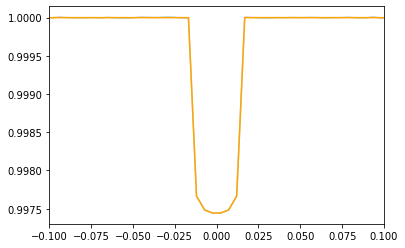

In [729]:
plt.plot(time, nflux, alpha=0.3)
plt.plot(time, fit, c='orange')
plt.xlim(-0.1, 0.1)

# Kepler Catalog Rhos

In [730]:
gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 36657.09it/s]


In [731]:
g_mean

1.3838527825921183

In [732]:
g_sigma

0.1746183136027173

In [733]:
np.mean(rhoe)

14595.138789382145

In [734]:
np.mean(rhoc)

34906.674878909274

# Gaia Rhos

In [735]:
gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos_gaia, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 21408.69it/s]


In [736]:
g_mean

0.9740846189194294

In [737]:
g_sigma

0.07129626690468016

In [738]:
np.mean(rhoe)

38949.79810546425

In [739]:
np.mean(rhoc)

35013.37613761981

In [740]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)

In [666]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [667]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 635.42it/s]


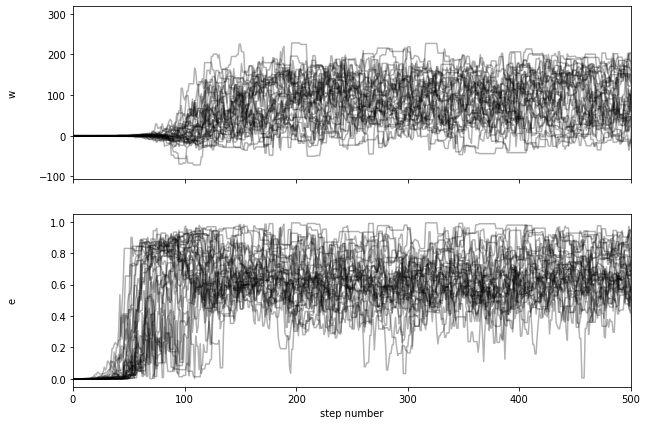

In [668]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [669]:
import corner

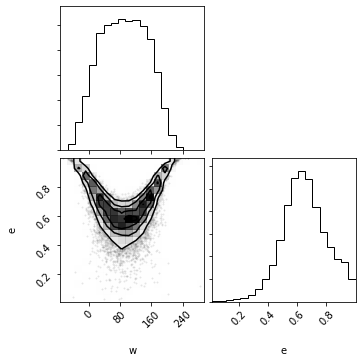

In [670]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

# Test in sequence

In [808]:
kepname = "Kepler-446 b"

smass, smass_uerr, smass_lerr, srad, srad_uerr, srad_lerr, ldmod, ldm_c1, ldm_c2 = ph.stellar_params_from_archive(spectplanets, kepname)
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a, a_uerr, a_lerr, i, e, w = ph.planet_params_from_archive(spectplanets, kepname)

smass_err = np.mean((smass_uerr, np.abs(smass_lerr)))
srad_err = np.mean((srad_uerr, np.abs(srad_lerr)))
period_err = np.mean((period_uerr, np.abs(period_lerr)))
rprs_err = np.mean((rprs_uerr, np.abs(rprs_lerr)))
a_err = np.mean((a_uerr, np.abs(a_lerr)))


print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  16.57
i:  89.99


In [809]:
print(i)

89.99


In [810]:
rho, ms, rs = ph.find_density_dist_symmetric(1, [smass], [smass_err], [srad], [srad_err])
rho[0].flatten();
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

print('Mean density: ', np.mean(rhos))

100%|██████████| 1/1 [00:00<00:00, 244.85it/s]

Mean density:  14406.30692873776


In [811]:
print(i)

89.99


In [815]:
def get_g_fake_transit(rhos, period, period_err, rprs, rprs_err, a, a_err, i):
    
    flux = planetlc(time, period, rprs, a, i)

    # Adding gaussian noise
    noise = np.random.normal(0,0.00005,len(time))
    nflux = flux+noise
    
    mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
    periodogram = mod.autopower(0.2, objective="snr")

    periodogram.period = np.asarray(periodogram.period)
    per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

    p0 = [per_guess, rprs, a, i]
    popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0)
    fit = planetlc(time, *popt)

    p = popt[0]*86400 #4.99 days
    perr = 0.001*86400

    rprs = popt[1] #0.0704 stellar radii
    rprserr = 0.001

    a = popt[2] #stellar radii

    i = popt[3] #degrees 

    T14n = ph.get_T14(p, rprs, a, i)
    T14err = 0.0001*86400

    T23n = ph.get_T23(p, rprs, a, i)
    T23err = 0.0001*86400

    gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
    gs = gs_t

    g_mean = np.mean(gs)
    g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))
    
    return g_mean, g_sigma

In [816]:
iters = 100
gs = []
g_sigmas = []

for j in range(iters):
    g, gsig = get_g_fake_transit(rhos, period, period_err, rprs, rprs_err, a, a_err, i)
    gs.append(g)
    g_sigmas.append(gsig)
    

100%|██████████| 1000/1000 [00:00<00:00, 81598.07it/s]


In [817]:
gs

[1.3928563369546603,
 1.3916744602788174,
 1.3903950474436761,
 1.393084567363877,
 1.3914005738738489,
 1.3932206741150195,
 1.391050380633587,
 1.3925318982902513,
 1.3993370553783098,
 1.3918462060483119,
 1.3905653772218234,
 1.392240393634019,
 1.3907662292950025,
 1.391397215594729,
 1.3975493768973233,
 1.3920542202664279,
 1.3917479681777227,
 1.3934655782982694,
 1.3938829132473625,
 1.3916838047713154,
 1.3952008362017863,
 1.4047379921709986,
 1.3957622678928174,
 1.3897356030880015,
 1.3917878565489423,
 1.3903817424568883,
 1.3931365354127976,
 1.3993241987158576,
 1.3883730713969142,
 1.3977130632122812,
 1.398304543758464,
 1.389186591386457,
 1.3898582793047858,
 1.3898348023189637,
 1.3920347940500926,
 1.3913918970277401,
 1.3918087858011174,
 1.3918596142559716,
 1.3898523228804798,
 1.3935650698909434,
 1.3912223069742509,
 1.3968235267100613,
 1.3992853366622384,
 1.3984352355436196,
 1.3923358310309557,
 1.3912691079655948,
 1.3912091641210134,
 1.3978817945519075